In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 25)

import pdb

from __future__ import division

Import outbreak data

In [2]:
measles_data = pd.read_csv("measles_.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [3]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [4]:
sp_pop = pd.read_csv('sp_pop.csv', index_col=0)

In [5]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [6]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

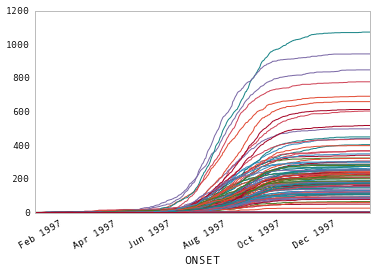

In [7]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

Top 5 districts by number of cases

In [8]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

## Chain Binomial Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple chain binomial model, which will be fit using MCMC.

This model fits the series of 2-week infection totals as a set of Binomial models:

\\[Pr(I_{t+1} | S_t, p_t) = \text{Bin}(S_t, p_t) \\]

Where the binomial probability is modeled as:

\\[p_t = 1 - \exp\(-\lambda_t\)\\]

\\[\lambda_t = \frac{B_t I_t}{N}\\]

\\[B_j = B_0\\]

which allows the effective reproductive number to be calculated as:

\\[R_t = \frac{\beta S_t}{N}\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. Theses estimaes are then plugged into the model in place of the clinically-confirmed cases.

Age classes are defined in 5-year intervals.

In [9]:
age_classes = [0,5,10,15,20,25,30,35,40,45,50,55,60,66,70,75,100]
measles_data.dropna(subset=['AGE'], inplace=True)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [10]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

In [11]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.YEAR_AGE.notnull() & measles_data.COUNTY.notnull()].copy()
lab_subset.loc[lab_subset.YEAR_AGE > 75, 'YEAR_AGE'] = 75
age = lab_subset.YEAR_AGE.astype(int).values
ages = lab_subset.YEAR_AGE.astype(int).unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

Extract cases by age and time.

In [12]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])

In [13]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [14]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [15]:
N = sp_pop.ix[unique_districts, 'Total'].dropna()

In [16]:
sp_districts = N.index.values
len(sp_districts)

93

In [17]:
all_district_data = []
for d in sp_districts:
    district_data = measles_data[measles_data.DISTRICT==d]
    district_counts_2w = district_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')
    all_district_data.append(district_counts_2w)

Time series of cases by district, summarized in 2-week intervals

In [18]:
# Sum over ages for susceptibles
sp_cases_2w = [dist.sum(1) for dist in all_district_data]

In [19]:
# Ensure the age groups are ordered
I_obs = np.array([dist.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int) for dist in all_district_data])

Check shape of data frame

In [20]:
assert I_obs.shape == (93, 28, 16)

### Spatial distance between districts

In [21]:
from shapely.geometry import Point, mapping, shape, MultiPolygon
from fiona import collection
import fiona

shp = fiona.open("Sao Paulo/Brazil_full/BRA_adm3.shp")

In [22]:
district_names = N.index.unique()

In [23]:
import trans
get_name = lambda x: trans.trans(x['properties']['NAME_3']).upper()
district_polygons = {get_name(pol): shape(pol['geometry']) for pol in shp 
                     if get_name(pol) in district_names}
# Number of matches between districts and polygons
len(district_polygons)

93

In [24]:
distances = {p1: {p2: district_polygons[p1].distance(district_polygons[p2]) 
                    for p2 in district_polygons if p2 in N.index} for p1 in district_polygons if p1 in N.index}
distance_matrix = pd.DataFrame(distances)
distance_matrix.shape

(93, 93)

In [25]:
_beta = -100
np.exp(_beta*distance_matrix).values.round(2)[0]

array([ 1.  ,  0.  ,  0.12,  0.  ,  0.  ,  0.01,  1.  ,  0.  ,  0.11,
        0.  ,  0.  ,  0.  ,  0.23,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,
        0.33,  0.  ,  0.  ,  0.  ,  0.02,  0.  ,  0.  ,  0.02,  0.  ,
        0.  ,  0.  ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.04,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.03,
        0.  ,  0.  ,  0.06,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.01,  0.  ,  0.04,  0.  ,  0.01,  0.  ,  0.  ,  1.  ,  0.01,
        0.  ,  0.  ,  0.09,  0.01,  0.02,  0.  ,  1.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  1.  ,  0.06,  0.  ,  0.  ,  0.11,  0.05,  0.06,
        0.01,  1.  ,  0.  ])

### Spatial decision model

We attempt to estimate $R_t$ for a truncated subset of the data, to simulate a decision-maker's information during (rather than after) an outbreak. This essentially involves turning part of the time series into missing data, and running the model.

This is an example of creating a mask for data not observed by the decision date.

In [26]:
np.array([np.resize(all_district_data[0].index > '1997-06-15', I_obs[0].T.shape).T]*len(all_district_data))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, 

In [27]:
from pymc import MCMC, Matplot
from pymc import (Uniform, DiscreteUniform, Beta, Lambda, Binomial, Normal, Poisson, 
                  NegativeBinomial, observed, negative_binomial_like, Lognormal, Exponential, binomial_like,
                  stochastic, potential, invlogit, TruncatedNormal, Binomial, Gamma)
from pymc import HalfCauchy, deterministic, MvNormalCov, Bernoulli, potential

### Confirmation sub-model

Specify priors on age-specific means

In [28]:
age_classes = np.unique(age_index)

mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
sig = HalfCauchy('sig', 0, 25, value=1)
var = sig**2
cov = Uniform('cov', -1000, 1000, value=0)

Build variance-covariance matrix with first-order correlation among age classes

In [29]:
@deterministic
def Sigma(var=var, cov=cov):
    I = np.eye(len(age_classes))*var
    E = np.diag(np.ones(len(age_classes)-1), k=-1)*cov
    return I + E + E.T

Age-specific probabilities of confirmation as multivariate normal random variables

In [30]:
beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, value=[1]*len(age_classes))
p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

@deterministic(trace=False)
def p_confirm(beta=beta_age):
    return invlogit(beta[age_index])

Confirmation likelihood

In [31]:
lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=y, observed=True)

### Missing data sub-model

We treat observations later than the decision date as missing data. This is implemented as a `masked_array` in NumPy, which requires a boolean mask to identify missing values.

In [32]:
obs_date='1997-06-15'

missing_mask = all_district_data[0].index > obs_date
district_mask = np.resize(missing_mask, I_obs[0].T.shape).T

I_obs_masked = ma.masked_array(I_obs,
                               mask=np.array([district_mask]*len(all_district_data)),
                               fill_value=1)

Index for observation date, used to index out values of interest from the model.

In [33]:
t_obs = (~missing_mask).sum() - 1

Imputed infecteds

In [34]:
I_imp = DiscreteUniform('I_imp', 0, 2000, value=I_obs_masked, observed=True)

### Chain binomial model for disease dynamics

Confirmed cases

In [35]:
@stochastic(trace=False, dtype=int)
def I(value=(I_imp.value*0.7).astype(int), n=I_imp, p=p_age):
    return np.sum([np.sum([binomial_like(vj[:,i], nj[:,i], p[i]) for i in range(len(p))]).sum(0) 
                            for vj, nj in zip(value, n)])

Infecteds at time $t_{obs}$

In [36]:
It = Lambda('It', lambda I=I: I.sum(0)[t_obs])

Calculate susceptibles from total number of infections

In [37]:
@deterministic(trace=False)
def S(I=I):
    return np.array([Ij.sum() - np.array([Ij[:i].sum() for i in range(len(Ij))]) for Ij in I])

Transmission parameter

In [38]:
beta = Gamma('beta', 1, 0.1, value=10) 

Calculation of the effective reproduction number depends on whether we believe that the districts are independent or not. If not (`spatially_weighted = True`), both the number of susceptibles and the denominator population are calculated as a distance-weighted average of all the districts in Sao Paulo.

In [39]:
spatially_weighted = True

if spatially_weighted:
    scale_factor = Exponential('scale_factor', 0.01, value=10)
    distance_weights = Lambda('distance_weights', lambda s=scale_factor: np.exp(-s*distance_matrix.values))

In [40]:
if spatially_weighted:
    Rt = Lambda('Rt', lambda B=beta, S=S, w=distance_weights: ((B * S).T / w.dot(N.values)).T)
else:
    Rt = Lambda('Rt', lambda B=beta, S=S: ((B * S).T / N.values).T)

Effective reproduction number at time of observation, and implied vaccination target

In [41]:
Rt_obs = Lambda('Rt_obs', lambda r=Rt: r[:, t_obs])
vaccination_target = Lambda('vaccination_target', lambda r=Rt_obs: np.maximum(1-1./r, 0))

Force of infection, assuming mass action transmission

In [42]:
if spatially_weighted:
    lam = Lambda('lam', lambda B=beta, I=I, w=distance_weights: 
                 np.array([(B * Ij) / nj for Ij,nj in zip(w.dot(I.transpose([1,0,2])), w.dot(N.values))]), 
                 trace=False)
else:
    lam = Lambda('lam', lambda B=beta, I=I: np.array([(B * Ij) / nj for Ij,nj in zip(I, N.values)]), 
                 trace=False)

2-week infection probabilities

In [43]:
p = Lambda('p', lambda lam=lam: 1. - np.exp(-lam) + 1e-6, trace=False)

Binomial likelihood for observed cases

In [44]:
@potential
def new_cases(p=p, I=I, S=S): 
    return np.sum([[binomial_like(i, s, pt) for pt,i,s in zip(pj[:t_obs], Ij[:t_obs], Sj[:t_obs])] 
                                               for pj,Ij,Sj in zip(p, I, S)])

In [45]:
model = MCMC(locals())

In [46]:
model.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 15922.5 sec

In [47]:
Rt_unc = model.Rt.stats()

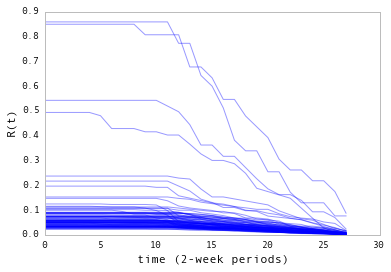

In [48]:
plt.plot(Rt_unc['quantiles'][97.5].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

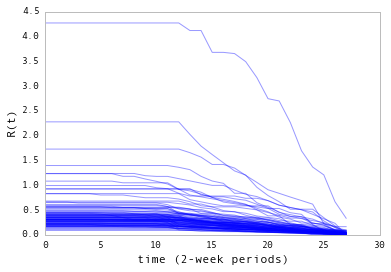

In [67]:
plt.plot(Rt_unc['quantiles'][97.5].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


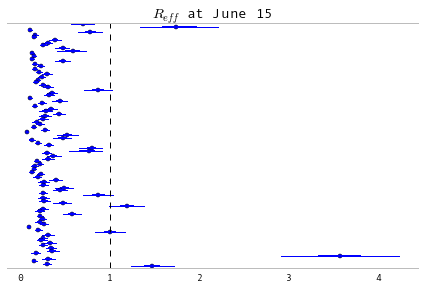

In [64]:
Matplot.summary_plot(model.Rt_obs, vline_pos=1, custom_labels=[''], main=r'$R_{eff}$ at June 15')

In [74]:
model.I.value.sum(0).shape

(28, 16)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


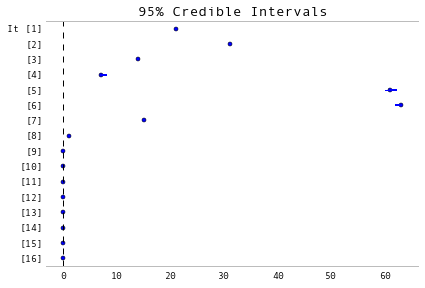

In [78]:
Matplot.summary_plot(model.It, custom_labels=measles_data['AGE_GROUP'].unique())